## Utility functions for Droplet MD Simulation Post-Processing

The following Notebook contains all functions for making use of the MD simulation trajectory files in PDB Format to obtain spatial density profile which is used to obtain the droplet diameter and droplet contact angle. The key parameters that need to specified in the cells that follows are : **N_molecules, N_timesteps, xlim, ylim, zlim and the filename passed to get_txt function which converts a PDB file to txt format**. 

In the computation of density, the user may choose to specify any other cell_size. dx and dz determine the grid spacing in the X and Z directions on which the computation is made approximating each dx.dz sized box as a cuboid.

As long as the standard PDB format file is used, none of the functions may be changed internally.

*Note - The drop is assumed to be resting on a substrate on the X-Y plane and the Z direction is normal to the substrate. This tutorial was used for a water droplet.*

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import jit

In [21]:
N_molecules = 1981 #Number of molecules having atom : atomname
N_timesteps = 200 #Number of time steps for which N_molecules trajectory was stored
xlim = [0,240] #Max Limits on X coord 
ylim = [0,240] #Max Limits on Y coord
zlim = [0,90]  #Max Limits on Z coord

In [22]:
#Use mask and apply it over all arrays
def get_clean_coord(X,Y,Z,timestep):
    i = timestep
    X_clean = np.ma.masked_where(X[:,i]>xlim[1], X[:,i]) 
    Y_clean = np.ma.masked_where(X[:,i]>xlim[1], Y[:,i])
    Z_clean = np.ma.masked_where(X[:,i]>xlim[1], Z[:,i])
    
    X_clean = np.ma.masked_where(X_clean[:]<xlim[0], X_clean[:]) 
    Y_clean = np.ma.masked_where(X_clean[:]<xlim[0], Y_clean[:])
    Z_clean = np.ma.masked_where(X_clean[:]<xlim[0], Z_clean[:])
    
    X_clean = np.ma.masked_where(Y_clean[:]>ylim[1], X_clean[:]) 
    Y_clean = np.ma.masked_where(Y_clean[:]>ylim[1], Y_clean[:]) 
    Z_clean = np.ma.masked_where(Y_clean[:]>ylim[1], Z_clean[:])
    
    X_clean = np.ma.masked_where(Y_clean[:]<ylim[0], X_clean[:]) 
    Y_clean = np.ma.masked_where(Y_clean[:]<ylim[0], Y_clean[:]) 
    Z_clean = np.ma.masked_where(Y_clean[:]<ylim[0], Z_clean[:])
    
    
    X_clean = np.ma.masked_where(Z_clean[:]>zlim[1], X_clean[:]) 
    Y_clean = np.ma.masked_where(Z_clean[:]>zlim[1], Y_clean[:])
    Z_clean = np.ma.masked_where(Z_clean[:]>zlim[1], Z_clean[:])
    
    X_clean = np.ma.masked_where(Z_clean[:]<zlim[0], X_clean[:]) 
    Y_clean = np.ma.masked_where(Z_clean[:]<zlim[0], Y_clean[:])
    Z_clean = np.ma.masked_where(Z_clean[:]<zlim[0], Z_clean[:])
    
    return X_clean, Y_clean, Z_clean
    

In [23]:

# Get coordinates of atom having name : atomname from file named : filename and store in a local txt file

def gen_txt(filename, atomname):
    pdb = open('./PDB/'+filename+'.pdb')
    trimmed_pdb = open('Coord_'+filename+'.txt',"w")
    for line in pdb:
        if line[0] == 'A' and line[13] == atomname:
            trimmed_pdb.write(line[31:45]+' '+line[47:55] +'\n')
    pdb.close()
    trimmed_pdb.close()
    
def get_coordinates(filename):
    trimmed_pdb = open('Coord_'+filename+'.txt')
    x = []
    for line in trimmed_pdb:
        x.append(line)
    
    X = np.zeros((N_molecules,N_timesteps))
    Y = np.zeros((N_molecules,N_timesteps))
    Z = np.zeros((N_molecules,N_timesteps))
    for j in range(0,N_molecules*N_timesteps):
        c = [float(i) for i in x[j].split()]
        i1 = j%N_molecules
        j1 = int(j/N_molecules)
        X[i1][j1] = c[0]
        Y[i1][j1] = c[1]
        Z[i1][j1] = c[2]
        
    return X,Y,Z

def plot_snapshot(X, Y, Z, timestep):
    plt.scatter(X[:,timestep],Z[:,timestep])


In [24]:
@jit
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [25]:
@jit
def get_rho(cell_size,xlim,ylim,zlim,x0,y0,z0,padding,dx,dz):
    
    p = cell_size/2
    q = padding
    Nx = int(1/dx)
    Nz = int(1/dz)
    #Populate Density Matrix for each cell
    rho = np.zeros(((xlim[1]-xlim[0]+2*q)*Nx,(zlim[1]-zlim[0]+2*q)*Nz))

    for x in range(-q*Nx,(xlim[1]-xlim[0]+q)*Nx):
        for z in range(-q*Nz,(zlim[1]-zlim[0]+q)*Nz):
            y_temp = y0[(x0>x/Nx+xlim[0]-p) & (x0<x/Nx+xlim[0]+p) & (z0>z/Nz+zlim[0]-p) & (z0<z/Nz+zlim[0]+p)]
            if y_temp.size != 0 and y_temp.max() != y_temp.min():
                rho[x+q*Nx][z+q*Nz] = y_temp.shape[0]/(y_temp.max()-y_temp.min())
    return rho 

In [26]:
def plot_rho(rho,padding,xlim,zlim,dx,dz):
    q = padding
    Nx = int(1/dx)
    Nz = int(1/dz)
    z_ax = np.linspace((zlim[0]-q)*Nz, (zlim[1]+q-1)*Nz,  (zlim[1]+2*q-zlim[0])*Nz)
    x_ax = np.linspace((xlim[0]-q)*Nx, (xlim[1]+q-1)*Nx,  (xlim[1]+2*q-xlim[0])*Nx)
    x_ax, z_ax = np.meshgrid(x_ax,z_ax)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(z_ax, x_ax, rho.T,cmap='viridis')
    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.set_title(r'Level Plot of $ \rho $')
    fig.colorbar(surf)
    ax.view_init(-90, 0)
    fig

In [31]:
#Example : Generate txt file of coordinates of oxygen ('O') from pdb file with name 'e=0.5_E=0' 
gen_txt('e=2.5_E=0','O')

In [32]:
X,Y,Z = get_coordinates('e=2.5_E=0')
q = 5 #Padding
dx = 0.1
dz = 0.1
Nx = int(1/dx)
Nz = int(1/dz)
cell_size = 6.8

In [15]:
#Get the Diameter List (this is slow!)
D = [] #Dia List
dx = 0.1
dz = 0.1
Nx = int(1/dx)
Nz = int(1/dz)
for t in range(50,100):
    x0,y0,z0 = get_clean_coord(X,Y,Z,t)
    xlim = [int(x0.min()),int(np.ceil(x0.max()))] #New Limits
    ylim = [int(y0.min()),int(np.ceil(y0.max()))] #New Limits
    zlim = [int(z0.min()),int(np.ceil(z0.max()))] #New Limits
    rho = get_rho(6.8,np.asarray(xlim),np.asarray(ylim),np.asarray(zlim),x0,y0,z0,q,dx,dz) #Get rho Cell_Size of 6.8
    r = rho.flatten()
    r = np.median(r)
    d = find_nearest(rho[:,(4+q)*Nz][int(rho.shape[0]/2):],r/2)+int(rho.shape[0]/2) -find_nearest(rho[:,(4+q)*Nz][0:int(rho.shape[0]/2)],r/2)
    D.append(d*dx)

Text(0.5, 0, 'Timestep')

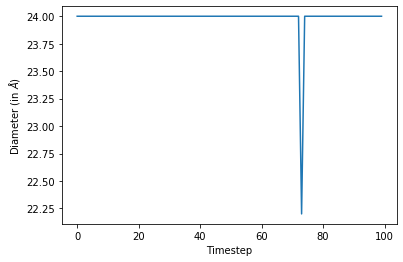

In [16]:
plt.plot(D)
plt.ylabel(r'Diameter (in $\AA$)')
plt.xlabel('Timestep')

In [20]:
x0,y0,z0 = get_clean_coord(X,Y,Z,99)
q=3

Text(0.5, 0, 'z-distance from bottom')

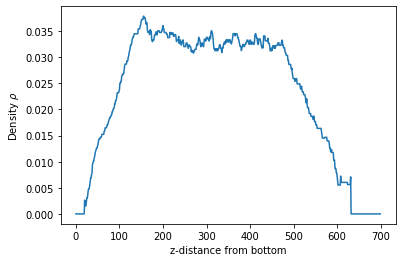

In [146]:
xlim = [int(x0.min()),int(np.ceil(x0.max()))] #New Limits
ylim = [int(y0.min()),int(np.ceil(y0.max()))] #New Limits
zlim = [int(z0.min()),int(np.ceil(z0.max()))] #New Limits
rho = get_rho(6.8,np.asarray(xlim),np.asarray(ylim),np.asarray(zlim),x0,y0,z0,q,dx,dz)
z_axis = np.linspace(0,zlim[1]-zlim[0]+2*q,rho.shape[1])
plt.plot(rho[int(rho.shape[0]*0.5),:]/(cell_size*cell_size))
plt.ylabel(r'Density $ \rho $')
plt.xlabel('z-distance from bottom')

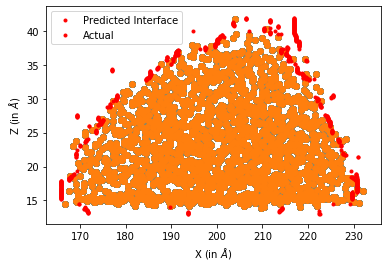

In [33]:
dx = 0.05
dz = 0.05
Nx = int(1/dx)
Nz = int(1/dz)
q = 3
cell_size = 6.8
x0,y0,z0 = get_clean_coord(X,Y,Z,100)
xlim = [int(x0.min()),int(np.ceil(x0.max()))]
ylim = [int(y0.min()),int(np.ceil(y0.max()))]
zlim = [int(z0.min()),int(np.ceil(z0.max()))]
rho = get_rho(6.8,np.asarray(xlim),np.asarray(ylim),np.asarray(zlim),x0,y0,z0,q,dx,dz) #Get rho Cell_Size of 6.8
r = rho.flatten()
r = np.median(r)*2
left_pts = []
right_pts = []
for z in range(0,rho.shape[1]-q*Nz-3*Nz):
    p1 = find_nearest(rho[:,int(z+q*Nz)],r/2)
    temp_idx = min(p1+int(rho.shape[0]*0.25),int(rho.shape[0]*0.75))
    p2 = find_nearest(rho[:,int(z+q*Nz)][temp_idx:],r/2)+temp_idx
    if p2 > p1:
        plt.plot(p1/Nx+xlim[0]-q, z/Nz+zlim[0],'r.')
        left_pts.append([p1/Nx+xlim[0]-q, z/Nz+zlim[0]])
        plt.plot(p2/Nx+xlim[0]-q, z/Nz+zlim[0],'r.')
        right_pts.append([p2/Nx+xlim[0]-q, z/Nz+zlim[0]])
        plt.scatter(x0,z0)
        plt.xlabel(r'X (in $\AA$)')
        plt.ylabel(r'Z (in $\AA$)')
        plt.legend(['Predicted Interface','Actual'])

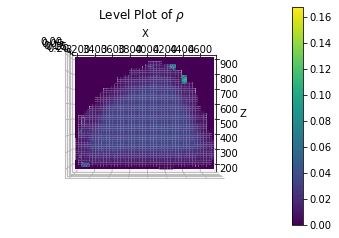

In [100]:
#Level Plot of Rho
plot_rho(rho/(cell_size*cell_size),q,xlim,zlim,dx,dz)


In [13]:
n = np.median(rho.flatten())*2/(cell_size**2)

N_A = 6.022*1e23 # Avogadro's Number
L_c = 1e-10 # 1 Angstorm to meter
M_Mass = 18 # Molecular Mass of Water

print('Predicted # Density of Water : ',n, '\n')
print('Predicted Density of Water:', n*18*1e-3/(N_A*L_c**3),'kg/m^3')


Predicted # Density of Water :  0.03183939620748707 

Predicted Density of Water: 951.6923476166842 kg/m^3


In [35]:
left_arr = np.squeeze(np.asarray(left_pts))
right_arr = np.squeeze(np.asarray(right_pts))

Text(203.91971985862875, 25, 'Left Angle:63.94')

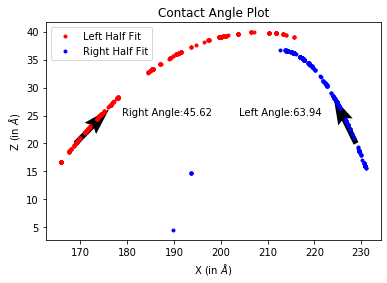

In [80]:
from scipy.optimize import curve_fit
def func(x,a,b,c):
    return a*x**2+b*x+c
def func_prime(x,a,b,c):
    return 2*a*x+b
    
zlevel = 20 #zlevel at which contact angle is measured


xdata = left_arr[:,0]
ydata = left_arr[:,1]
popt, pcov = curve_fit(func, xdata, ydata)

x_at_zlevel = (-popt[1]+np.sqrt(popt[1]**2-4*popt[0]*(popt[2]-zlevel)))/(2*popt[0])

v = np.array([1,func_prime(x_at_zlevel,*popt)])
origin = [x_at_zlevel],[zlevel]
right_angle = int(np.arctan(v[1]/v[0])*180/np.pi*100)/100
plt.quiver(*origin, v[0], v[1], color=['k'], scale=10, width=0.016)
plt.plot(xdata,func(xdata,*popt),'r.')
plt.text(x_at_zlevel+10,zlevel+5,'Right Angle:'+str(right_angle))

xdata = right_arr[:,0]
ydata = right_arr[:,1]
popt, pcov = curve_fit(func, xdata, ydata) #Fitting to get polynomial coefficients in popt

x_at_zlevel = (-popt[1]-np.sqrt(popt[1]**2-4*popt[0]*(popt[2]-zlevel)))/(2*popt[0])
v = np.array([-1,-func_prime(x_at_zlevel,*popt)])
origin = [x_at_zlevel],[zlevel]
left_angle = int(-np.arctan(v[1]/v[0])*180/np.pi*100)/100
plt.quiver(*origin, v[0], v[1], color=['k'], scale=15,width=0.016)

plt.plot(xdata,func(xdata,*popt),'b.')
plt.xlabel(r'X (in $\AA$)')
plt.ylabel(r'Z (in $\AA$)')
plt.title('Contact Angle Plot')
plt.legend(['Left Half Fit','Right Half Fit'])

plt.text(x_at_zlevel-25,zlevel+5,'Left Angle:'+str(left_angle))


In [75]:
xdata = np.hstack((left_arr[:,0],right_arr[:,0]))
ydata = np.hstack((left_arr[:,1],right_arr[:,1]))

indices = np.argsort(xdata)
xdata = np.sort(xdata)
ynew = np.zeros(ydata.shape)
j = 0
for i in indices:
    ynew[j] = ydata[i]
    j=j+1

xdata = xdata[(ynew > 17 )]
ynew = ynew[(ynew > 17)]


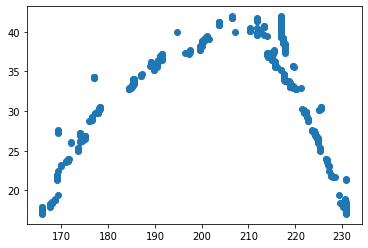

In [140]:
plt.scatter(xdata,ynew)

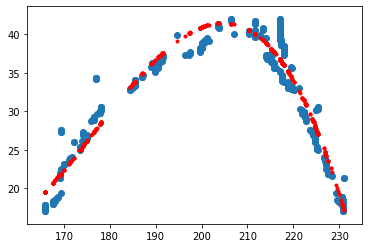

In [144]:
from scipy.optimize import curve_fit
def func(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

popt, pcov = curve_fit(func, xdata, ynew)

plt.plot(xdata,func(xdata,*popt),'r.')

plt.scatter(xdata,ynew)

In [87]:
print(yy)

[17.4547619  17.66785714 17.80357143 17.86190476 17.75       17.7
 17.65       17.6047619  17.53809524 17.50238095 17.44285714 17.36904762
 17.29047619 17.21666667 17.10238095 17.0547619  17.18333333 17.44761905
 17.77619048 18.         18.12619048 18.14047619 18.16428571 18.18809524
 18.23333333 18.24047619 18.32142857 18.40238095 18.44047619 18.50714286
 18.6        18.7        18.56428571 18.9547619  19.71190476 20.63333333
 21.45238095 21.91666667 21.77380952 21.8        21.90714286 21.77619048
 21.32619048 22.17857143 24.55714286 24.53095238 24.96428571 25.1952381
 25.11428571 26.34047619 28.67857143 27.31904762 26.01428571 24.48809524
 23.30714286 22.83571429 23.46428571 23.71190476 23.85714286 23.84761905
 23.80714286 23.56666667 23.9047619  24.65238095 25.28333333 25.66428571
 25.65238095 25.2452381  25.19761905 25.28095238 25.21666667 25.03809524
 25.03571429 25.52142857 25.96190476 26.47619048 26.89285714 27.01190476
 27.07619048 27.25238095 27.1452381  26.97142857 26.7333333